### lecture 3: Bellman Optimality Equation

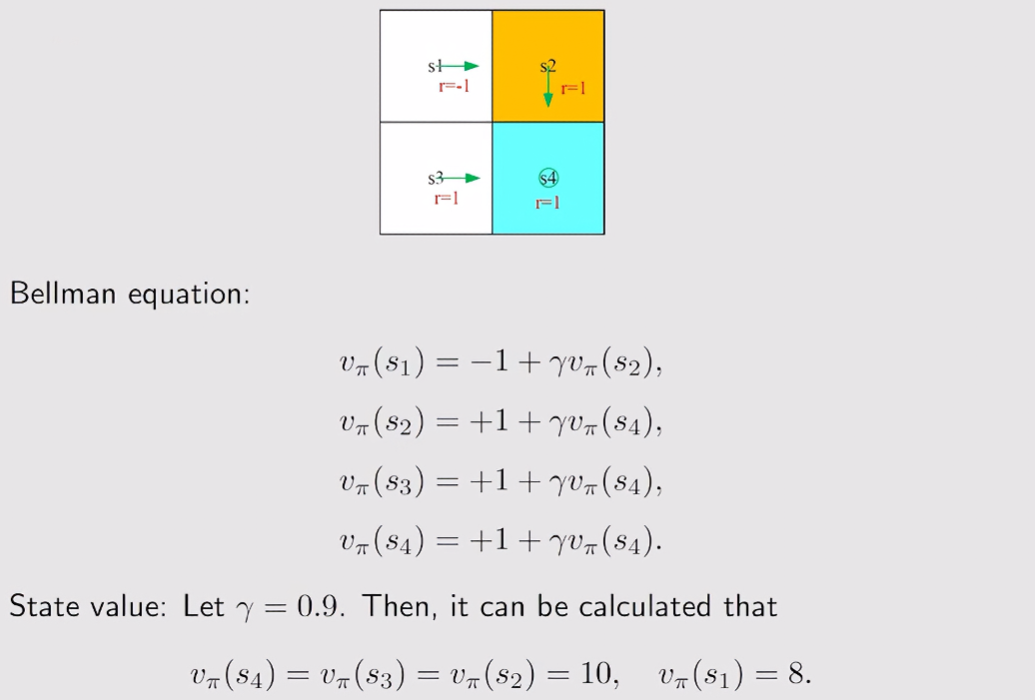

In [3]:
import numpy as np
from bellman_equation import *

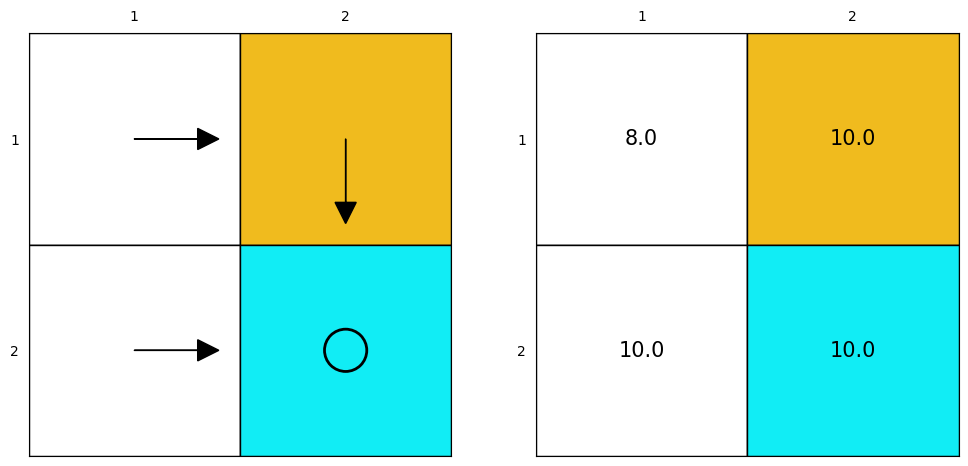

In [2]:
forbiddens_ex1 = {(2, 1)}
targets_ex1 = {(2, 2)}
PI_ex1 = [
    ['right', 'down'],
    ['right', None]
]
v_ex1 = iterative_solution_state_value_from_bellman(PI_ex1, forbiddens_ex1, targets_ex1, T=100, gamma=0.9)

根据上图的 `state value`，易得 `action value`  

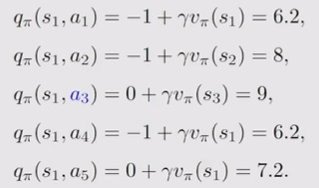

所以 $a = a_3$ 对应的 `action value` 最大，$a_3$是个更好的策略  

$a^* = \arg\max_a  q_\pi(s_1, a) = a_3$  

如果对于所有的 `state`， $\pi^*$ 的 `state value` 都大于等于任意其他策略 $\pi_i$ 对应的 `state value`，则 $\pi^*$ 为**最优策略**

因此，贝尔曼最优公式如下：  
- element-wise form：  
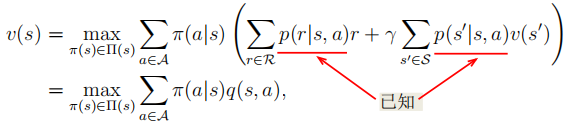  

- matrix-vector form：  
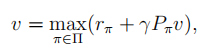  

其中未知量为 $v$ 和 $\pi$，如何从一个公式中求解两个未知量？

> 假设存在两个未知量 $x, a \in R $，他们满足：  
> $ x = \max_a (2x - 1 - a^2)$  
>1\. 考虑右式 $\max_a (2x - 1 - a^2)$，显然当 $ a=0 $ 时取得最大值；  
>2\. $a=0$ 代入得： $ x = 2x - 1 $，因此 $ x = 1 $；  
>3\. 解为 $ a=0, x=1 $.  

**首先**，固定 $ v'(s)$ (一般可初始化为 0 )，求解 $ \pi $.  

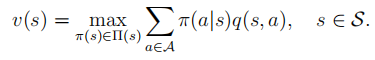

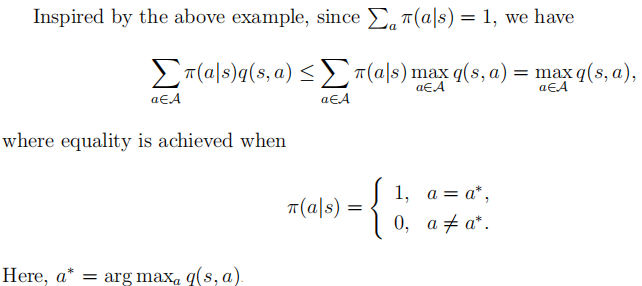  

因此，最优的 $ \pi $ 即为选择 `action value` $ q(s, a)$ 最大的那个 $a$.  

**然后**，由于一旦 & v & 给定，即可求得最优的 $ \pi $，故右式可视作关于 $v$ 的函数：  

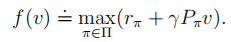

因此，贝尔曼最优公式形式如下：  



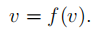

> **Contraction mapping theorem**  
> 
> For any equation that has the form of $ x = f(x)$, if $f$ is a contraction mapping, then:  
> - 存在性: there exists a fixed point $x^∗$ satisfying $f(x^∗) = x^∗$.  
> - 唯一性: The fixed point $x∗$ is unique.  
> - 解算法: Consider a sequence $\{x_k\}$ where $x_{k+1} = f(x_k)$, then $x_k → x^* $ as $k→∞$. 
> 
> The function $f$ is a contracting mapping if exists $\gamma \in (0, 1)$ such that $ \|f(x_1) - f(x_2)\| \leq \gamma \|x_1 - x_2\| $  
>
>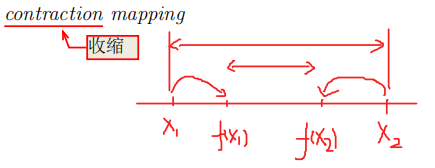

根据**Contraction mapping theorem**，贝尔曼最优公式必然存在一个解$v^*$，可以通过迭代求得：

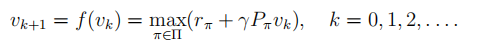

一旦求得$v^*$，$\pi^*$也可得到

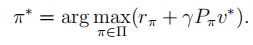  

**贝尔曼最优公式算法代码实现**

上述贝尔曼最优公式为：  

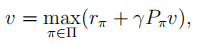

理论上可通过迭代求解，但若编程对该公式求解存在一个绕不开的问题：`算法复杂度`  

- 策略空间大小 $ |\Pi| = |A|^{|S|} $，$|A|$是action数量，$|S|$是state数量，在这里分别表示动作数量和格子数  
- 这个策略空间是指数级的，不可能直接枚举，因此该贝尔曼最优公式仅用来做理论证明，不能用于写代码。

⭐关键等价：$max_\pi $ ⇔ 状态上逐点 $ max_a$  

对于贝尔曼最优公式

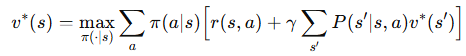

等式右边部分如下：

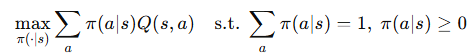

显然最优策略满足：

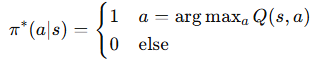

因此：

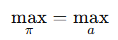 

于是，贝尔曼最优公式严格等价于：

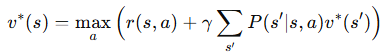

In [28]:
# 迭代求解上述对动作取max的贝尔曼最优公式
# input参数：
# n: 网格大小
# T: 迭代次数
# A: 动作空间
# gamma: 折扣因子

ActionSpace = ['up', 'right', 'down', 'left', None]

def iterative_solution_BOE(n,forbiddens, targets, T, A, gamma=0.9):
    v = np.zeros(n*n) # 初始化状态价值函数
    r = np.zeros((len(A),n*n)) # 初始化奖励函数r[a][s]
    p = np.zeros((len(A), n*n, n*n)) # 初始化状态转移概率p[a][s][s'] 

    for i in range(n):
        for j in range(n):
            s = i * n + j # 状态编号
            # 计算奖励函数r[s][a]和状态转移概率p[s][a][s']
            for a in range(len(A)):
                next_i, next_j = i, j
                action = A[a]
                idx = 0 # 用于标记r[idx][s]的值
                if action == 'up':
                    next_i -=1
                    idx = 0 
                elif action == 'right':
                    next_j += 1
                    idx = 1
                elif action == 'down':
                    next_i += 1
                    idx = 2 
                elif action == 'left':
                    next_j -= 1
                    idx = 3
                elif action is None:
                    idx = 4
                else:
                    raise ValueError("Invalid Action")
                             
                next_state = (next_j + 1, next_i + 1) # 转换为从 (1,1) 开始计数的坐标
                if next_state in targets:
                    r[idx][s] = 1
                elif next_state in forbiddens:
                    r[idx][s] = -1
                elif next_i < 0 or next_i >= n or next_j < 0 or next_j >= n:
                    r[idx][s] = -1
                else:
                    r[idx][s] = 0

                # 状态转移概率
                if next_i < 0: next_i = 0
                if next_i >= n: next_i = n - 1
                if next_j < 0: next_j = 0
                if next_j >= n: next_j = n - 1
                s_next = next_i * n + next_j
                p[idx][s][s_next] = 1.0


    # 迭代更新状态价值函数v
    for _ in range(T):
        q = np.zeros((len(A), n*n)) # 初始化动作价值函数q[a][s]
        for a in range(len(A)):
            q[a] = r[a] + gamma * np.dot(p[a], v)
        v = np.max(q, axis=0)

    # 根据最终的状态价值函数v，计算最优策略pi*
    # pi*(s) = argmax_a [ r(s,a) + gamma * sum_{s'} p(s'|s,a) v(s') ]
    pi_star = np.zeros((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            s = i * n + j # 状态编号
            q_s = np.zeros(len(A))
            for a in range(len(A)):
                q_s[a] = r[a][s] + gamma * np.dot(p[a][s], v)
            
            # 若多个动作价值相同，则选择第一个
            # best_a = np.argmax(q_s) 

            # 若多个动作价值相同，则随机选择一个
            max_a = np.max(q_s)
            best_a = np.random.choice(np.where(q_s == max_a)[0])

            pi_star[i][j] = A[best_a]

    return pi_star, v.reshape((n, n))


**Note**：由于若多个动作价值相同，则随机选择一个，故结果可能和示例有所不同

Example 1:  
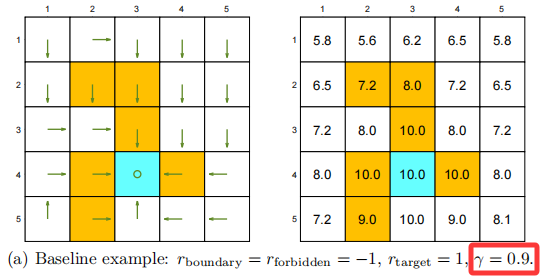

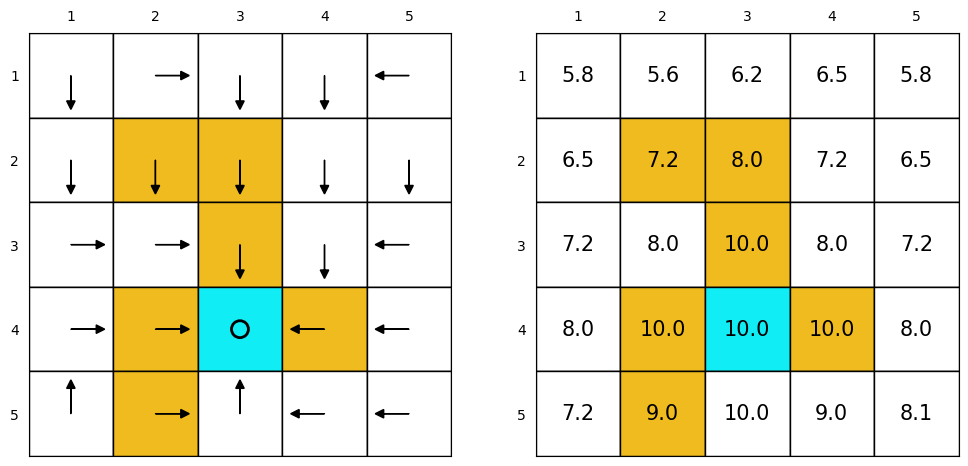

In [32]:
forbiddens = {(2, 2), (2, 4), (2, 5), (3, 2), (3, 3), (4, 4)}
targets = {(3, 4)}

pi_star_ex1, v_ex1 = iterative_solution_BOE(n=5, forbiddens=forbiddens, targets=targets, T=100, A=ActionSpace, gamma=0.9)
draw_grid(n=5, forbidden=forbiddens, targets=targets, PI=pi_star_ex1, V=v_ex1)

Example 2:  
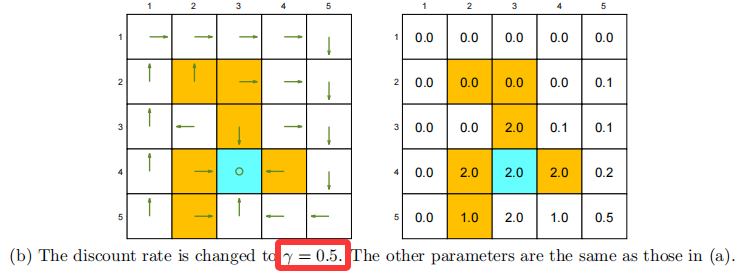

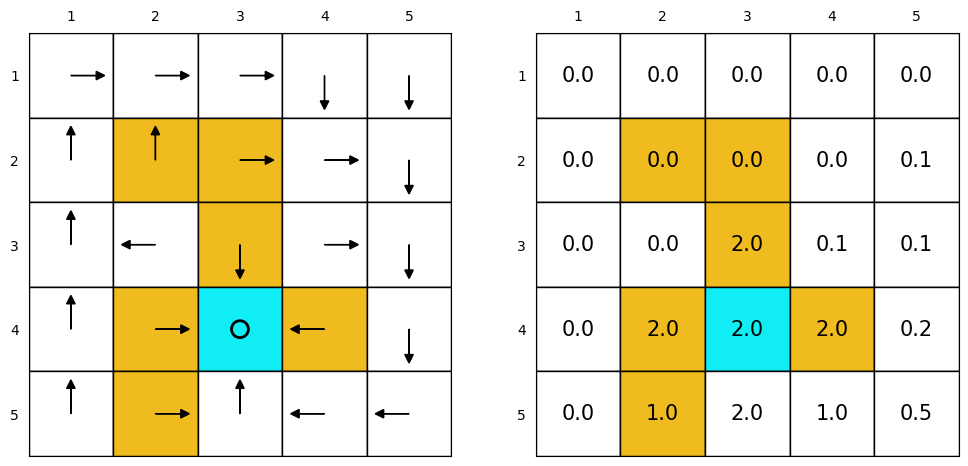

In [33]:
pi_star_ex2, v_ex2 = iterative_solution_BOE(n=5, forbiddens=forbiddens, targets=targets, T=100, A=ActionSpace, gamma=0.5)
draw_grid(n=5, forbidden=forbiddens, targets=targets, PI=pi_star_ex2, V=v_ex2)

Example 3:  
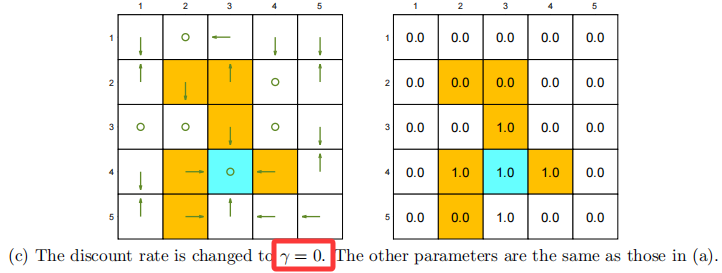

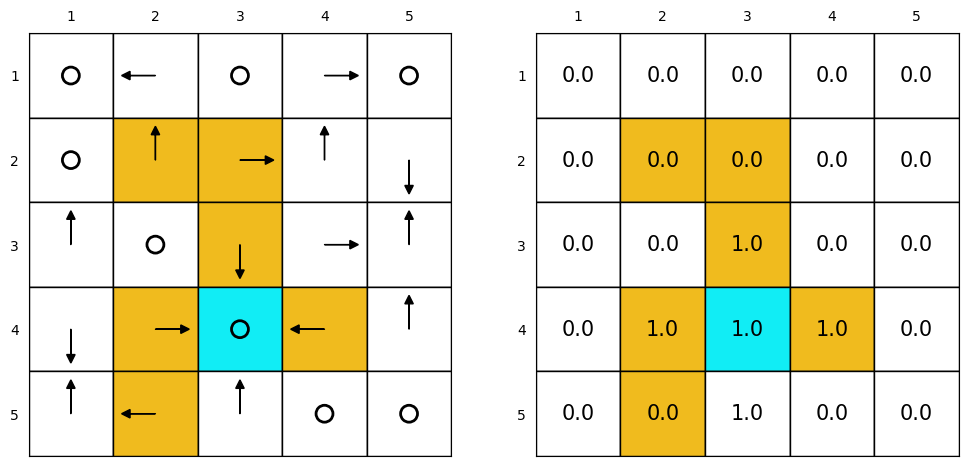

In [34]:
pi_star_ex2, v_ex2 = iterative_solution_BOE(
    n=5, forbiddens=forbiddens, targets=targets, T=100, A=ActionSpace, gamma=0
)
draw_grid(n=5, forbidden=forbiddens, targets=targets, PI=pi_star_ex2, V=v_ex2)